# NYC Airbnb Price Analysis & Prediction

This notebook explores Airbnb prices in NYC, performs exploratory analysis, 
and builds machine learning models to predict nightly price.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("data/listings.csv")   
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36230 entries, 0 to 36229
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36230 non-null  int64  
 1   listing_url                                   36230 non-null  object 
 2   scrape_id                                     36230 non-null  int64  
 3   last_scraped                                  36230 non-null  object 
 4   name                                          36216 non-null  object 
 5   description                                   34991 non-null  object 
 6   neighborhood_overview                         22603 non-null  object 
 7   picture_url                                   36230 non-null  object 
 8   host_id                                       36230 non-null  int64  
 9   host_url                                      36230 non-null 

## 1. Load data and initial inspection

In [ ]:
df.columns
df.isna().sum()
df.describe(include="all")

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.623000e+04,36230,3.623000e+04,36230,36216,34991,22603,36230,3.623000e+04,36230,...,26108.000000,26093.000000,26093.000000,0.0,36230,36230.000000,36230.000000,36230.000000,36230.000000,26772.000000
unique,NaN,36230,NaN,6,35043,32922,18637,35222,NaN,25679,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/2595,NaN,2021-06-04,Well-kept apartment home | 1BR in New York,Stay for 31+ nights (minimum nights and rates ...,The Greenpoint House in only a few short block...,https://a0.muscache.com/pictures/6998e77e-4564...,NaN,https://www.airbnb.com/users/show/305240193,...,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,11321,34,53,57,37,NaN,283,...,NaN,NaN,NaN,NaN,26259,NaN,NaN,NaN,NaN,NaN
mean,2.634218e+07,NaN,2.021060e+13,NaN,NaN,NaN,NaN,NaN,1.009300e+08,NaN,...,4.825011,4.760649,4.660838,NaN,NaN,12.249738,6.449324,5.626884,0.090781,1.199019
std,1.587173e+07,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,1.176057e+08,NaN,...,0.436054,0.400165,0.494472,NaN,NaN,41.304267,29.272265,26.253576,1.183704,3.274870
min,2.595000e+03,NaN,2.021060e+13,NaN,NaN,NaN,NaN,NaN,2.438000e+03,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.178345e+07,NaN,2.021060e+13,NaN,NaN,NaN,NaN,NaN,1.026437e+07,NaN,...,4.830000,4.670000,4.570000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.110000
50%,2.668092e+07,NaN,2.021060e+13,NaN,NaN,NaN,NaN,NaN,4.367301e+07,NaN,...,4.980000,4.880000,4.790000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.400000
75%,4.143450e+07,NaN,2.021060e+13,NaN,NaN,NaN,NaN,NaN,1.632510e+08,NaN,...,5.000000,5.000000,5.000000,NaN,NaN,3.000000,1.000000,1.000000,0.000000,1.340000


## 2. Data cleaning
- Select relevant columns.
- Handle missing values.
- Remove/limit extreme prices.

In [ ]:
cols_keep = [
    "id", "name", "host_id", "neighborhood_overview", "neighbourhood",
    "latitude", "longitude", "room_type", "price",
    "minimum_nights", "number_of_reviews",
    "last_review", "reviews_per_month",
    "calculated_host_listings_count", "availability_365"
]

df = df[cols_keep]
df.head()

,id,name,host_id,neighborhood_overview,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Centrally located in the heart of Manhattan ju...,"New York, United States",40.75356,-73.98559,Entire home/apt,$150.00,30,48,2019-11-04,0.34,3,308
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,Just the right mix of urban center and local n...,"Brooklyn, New York, United States",40.68494,-73.95765,Entire home/apt,$79.00,1,403,2021-05-04,5.16,1,208
2,5121,BlissArtsSpace!,7356,NaN,NaN,40.68535,-73.95512,Private room,$60.00,30,50,2016-06-05,0.56,1,365
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,NaN,NaN,40.66265,-73.99454,Entire home/apt,$175.00,21,1,2014-01-02,0.01,1,134
4,5178,Large Furnished Room Near B'way,8967,"Theater district, many restaurants around here.","New York, United States",40.76457,-73.98317,Private room,$61.00,2,474,2020-09-25,3.61,1,246


In [ ]:
# Clean price column
df["price"] = (
    df["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Remove rows with price <= 0
df = df[df["price"] > 0]

# Handle missing reviews_per_month
if "reviews_per_month" in df.columns:
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# Convert last_review to datetime
if "last_review" in df.columns:
    df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36192 entries, 0 to 36229
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              36192 non-null  int64         
 1   name                            36178 non-null  object        
 2   host_id                         36192 non-null  int64         
 3   neighborhood_overview           22603 non-null  object        
 4   neighbourhood                   22604 non-null  object        
 5   latitude                        36192 non-null  float64       
 6   longitude                       36192 non-null  float64       
 7   room_type                       36192 non-null  object        
 8   price                           36192 non-null  float64       
 9   minimum_nights                  36192 non-null  int64         
 10  number_of_reviews               36192 non-null  int64         
 11  last_re

## 3. Exploratory data analysis
### 3.1 Price distribution

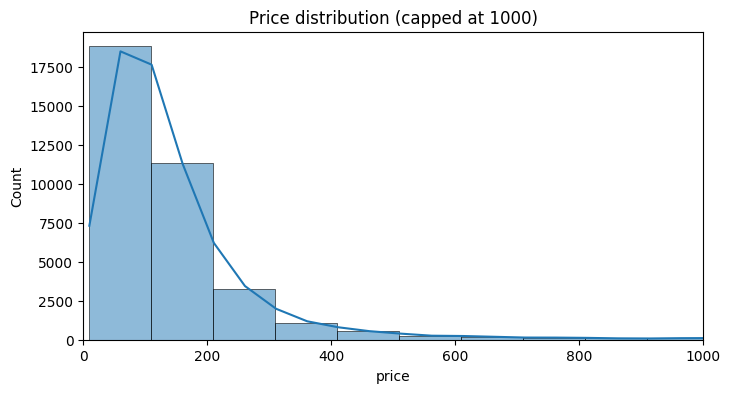

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["price"], bins=100, kde=True)
plt.xlim(0, 1000)  
plt.title("Price distribution (capped at 1000)")
plt.savefig("images/histogram.png", dpi=300, bbox_inches="tight")
plt.show()
df_eda = df[df["price"] <= 500]  

### 3.2 Price by room type

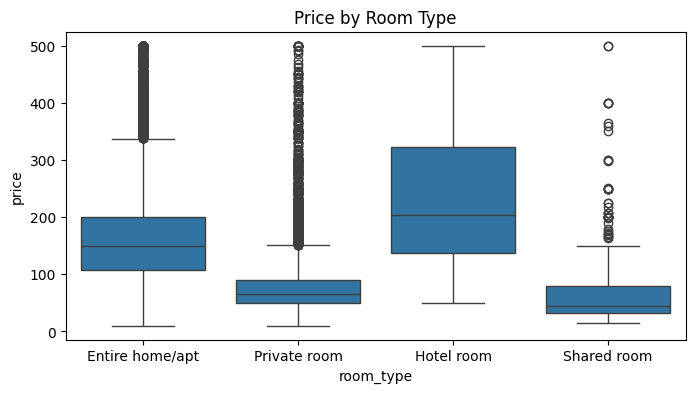

In [7]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_eda, x="room_type", y="price")
plt.title("Price by Room Type")
plt.savefig("images/boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# groupby stats
df_eda.groupby("room_type")["price"] \
      .agg(["count", "mean", "median"]) \
      .sort_values("mean", ascending=False)

,count,mean,median
room_type,,,
Hotel room,198,234.757576,203.0
Entire home/apt,18376,171.128864,150.0
Private room,15926,78.046904,65.0
Shared room,627,66.838915,45.0


In [ ]:
df_eda.groupby("neighbourhood")["price"] \
      .agg(["count", "mean", "median"]) \
      .sort_values("mean", ascending=False)

,count,mean,median
neighbourhood,,,
"FOREST HILLS, New York, United States",1,395.0,395.0
"Queens-Rego Park, New York, United States",1,368.0,368.0
"New York, NY, Argentina",1,367.0,367.0
"Cambria Heights, New York, United States",1,364.0,364.0
"Jamaica queens, New York, United States",1,350.0,350.0
...,...,...,...
"forest hills/corona, New York, United States",1,39.0,39.0
"Far Rockaway, New York, United States",4,38.0,38.0
"Bronx, NY, New York, United States",1,38.0,38.0


### 3.3 Location scatter (price on map)

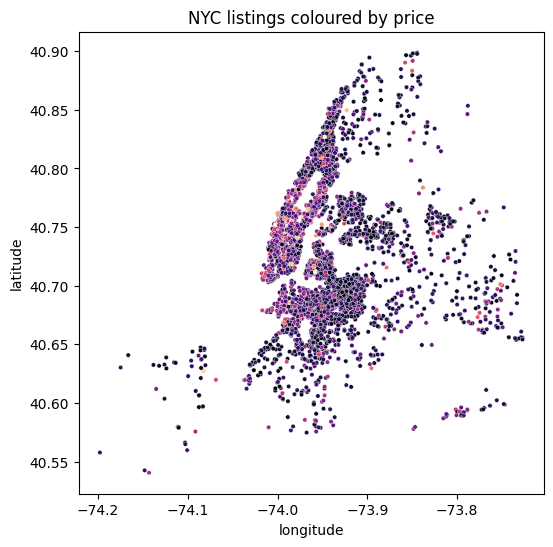

In [ ]:
# scatter map 
df_map = df_eda.sample(n=min(5000, len(df_eda)), random_state=42)

plt.figure(figsize=(6,6))
sns.scatterplot(data=df_map, x="longitude", y="latitude", hue="price", palette="magma", s=10)
plt.title("NYC listings coloured by price")
plt.legend([],[],frameon=False)
plt.savefig("images/scatterplot.png", dpi=300, bbox_inches="tight")
plt.show()

### 3.4 Numeric correlations

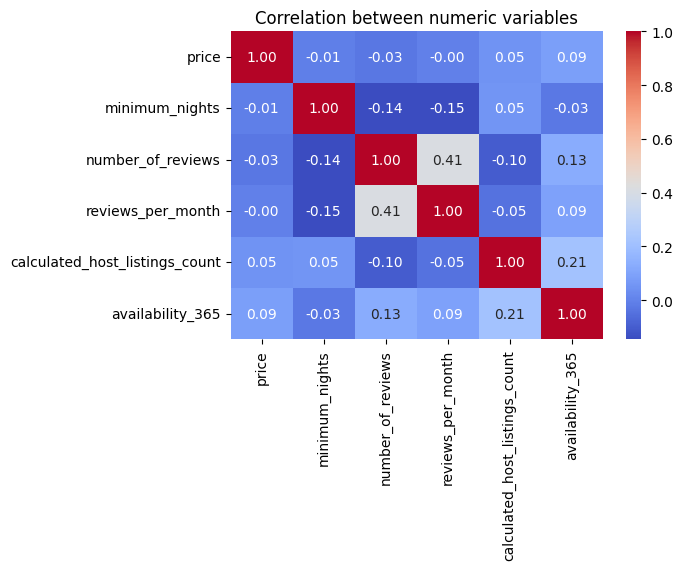

In [ ]:
numeric_cols = ["price", "minimum_nights", "number_of_reviews","reviews_per_month", "calculated_host_listings_count",
                "availability_365"]

corr = df_eda[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between numeric variables")
plt.savefig("images/heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
df.columns.tolist()

['id',
 'name',
 'host_id',
 'neighborhood_overview',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

## 4. Feature engineering and modelling
### 4.1 Prepare features and target

In [ ]:
target = "price"

features = [
    "neighbourhood",
    "latitude", "longitude",
    "room_type",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"
]

data_ml = df_eda[features + [target]].dropna()
data_ml.shape

(22012, 10)

In [ ]:
X = pd.get_dummies(
    data_ml[features],
    columns=["neighbourhood", "room_type"],
    drop_first=True
)
y = data_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((17609, 218), (4403, 218))

### 4.2 Baseline and Linear Regression

In [ ]:
# baseline: always predict training mean
y_mean = y_train.mean()
y_pred_baseline = np.full_like(y_test, fill_value=y_mean, dtype=float)

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print("Baseline MAE:", mae_baseline)
print("Baseline RMSE:", rmse_baseline)

# linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)

Baseline MAE: 65.72236580443949
Baseline RMSE: 87.75687384225385
Linear Regression MAE: 48.61987765398277
Linear Regression RMSE: 69.76955454788573


### 4.3 Random Forest

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest MAE: 42.710678947254586
Random Forest RMSE: 64.4905545200884


In [ ]:
results = {
    "Baseline": (mae_baseline, rmse_baseline),
    "Linear Regression": (mae_lr, rmse_lr),
    "Random Forest": (mae_rf, rmse_rf),
}
results

{'Baseline': (65.72236580443949, np.float64(87.75687384225385)),
 'Linear Regression': (48.61987765398277, np.float64(69.76955454788573)),
 'Random Forest': (42.710678947254586, np.float64(64.4905545200884))}

### 4.4 Feature importance

In [ ]:
importances = rf.feature_importances_
feat_names = X_train.columns

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)

,feature,importance
216,room_type_Private room,0.279659
1,longitude,0.200152
0,latitude,0.161035
6,availability_365,0.083632
4,reviews_per_month,0.072067
3,number_of_reviews,0.061723
5,calculated_host_listings_count,0.061691
2,minimum_nights,0.038812
217,room_type_Shared room,0.026022
35,"neighbourhood_Brooklyn, New York, United States",0.002555


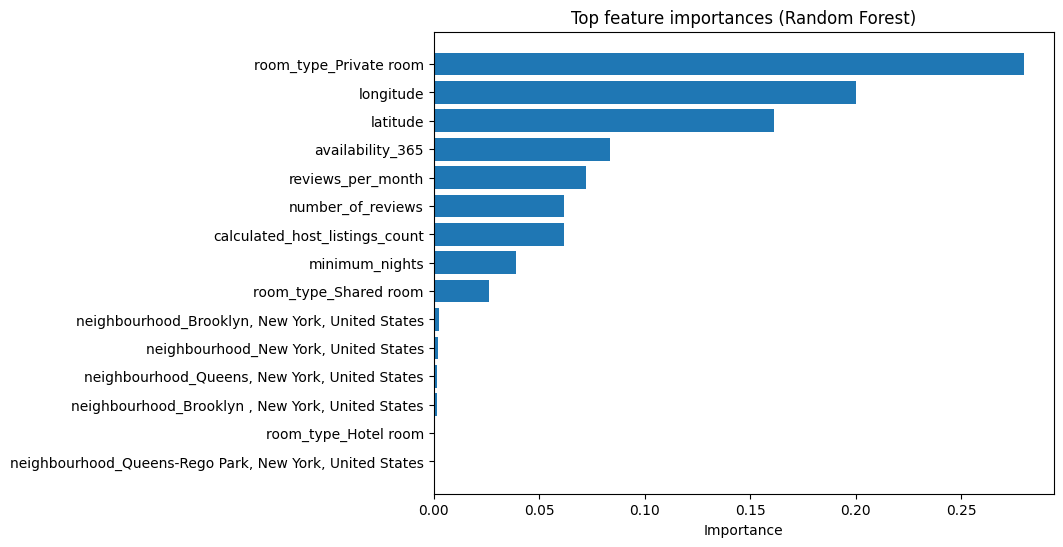

In [ ]:
top_n = 15
plt.figure(figsize=(8,6))
plt.barh(fi["feature"].head(top_n)[::-1],
         fi["importance"].head(top_n)[::-1])
plt.title("Top feature importances (Random Forest)")
plt.xlabel("Importance")
plt.savefig("images/price_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
import os
os.makedirs("images", exist_ok=True)

## KEY FINDINGS


### EDA insights
1. Airbnb prices in NYC are highly right‑skewed, with most listings below roughly 200–300 per night and a long tail of expensive properties, so extreme prices were capped when analysing and modelling.
2. Entire homes/apartments and hotel rooms have much higher median prices than private and shared rooms, confirming that room type is a major driver of price.
3. Visualizing listings on a longitude–latitude scatter shows high‑priced listings concentrated in specific central areas of the city, reflecting location premiums.


### Model performance
1. A simple baseline model that always predicts the mean price achieves MAE ≈ 65.7, while Linear Regression improves this to ≈ 48.6 and Random Forest reduces it further to ≈ 42.7, a substantial error reduction compared to the baseline.
2. Random Forest also achieves the lowest RMSE, indicating it handles large price deviations better than the simpler models.


### Feature importance insights
1. Random Forest feature importances show room_type and precise geographic coordinates (longitude, latitude) as the strongest predictors of price, highlighting the combined effect of property type and location.
2. Booking behaviour and host activity features such as availability_365, reviews_per_month, number_of_reviews, and calculated_host_listings_count also contribute meaningfully, suggesting that frequently booked or highly reviewed listings tend to follow different pricing patterns.